In [1]:

# %pip cache purge
# %pip install librosa==0.10.1
# %pip install llvmlite==0.43.0
# %pip install pandas==1.5.3
# %pip install protobuf==3.20.3
# %pip install click==8.1.3
# %pip uninstall tensorflow tensorflow-macos tensorflow-metal tensorflow-estimator tensorflow-io-gcs-filesystem -y

# %pip install tensorflow-macos tensorflow-metal

from random_forest_utils import random_forest
from logistic_regression_utils import logistic_regression
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf

In [2]:
# %pip list | grep tensorflow
# print("TensorFlow Version:", tf.__version__)
# print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
# print("Available GPUs:", tf.config.list_physical_devices('GPU'))
# import tensorflow as tf
# print("TensorFlow is imported from:", tf.__file__)
# import os

# print("Files in Current Directory:")
# print(os.listdir('.'))

In [ ]:

DATA_DIR = "/Users/dmwelch/Development/NYU/MIR/finalProj/Data/genres_original"

def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=30)
    features = np.array([])

    # MFCC
    
    s = librosa.feature.mfcc(y=y, sr=sr)
    mfccs_mean = mfccs.mean(axis=1)
    features = np.hstack((features, mfccs_mean))

    # Chromagram
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = chroma.mean(axis=1)
    features = np.hstack((features, chroma_mean))

    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast_mean = contrast.mean(axis=1)
    features = np.hstack((features, contrast_mean))

    # Tonnetz
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    tonnetz_mean = tonnetz.mean(axis=1)
    features = np.hstack((features, tonnetz_mean))

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = zcr.mean()
    features = np.hstack((features, zcr_mean))

    # Spectral Roll-off
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rolloff_mean = rolloff.mean()
    features = np.hstack((features, rolloff_mean))

    return features

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
# dataset = []

# for genre in genres:
#     genre_dir = os.path.join(DATA_DIR, genre)
#     for filename in os.listdir(genre_dir):
#         if filename.endswith('.wav'):
#             file_path = os.path.join(genre_dir, filename)
#             features = extract_features(file_path)
#             dataset.append([features, genre])


# # Convert to DataFrame
# df = pd.DataFrame(dataset, columns=['features', 'label'])

import pickle

# # Save the DataFrame
# with open('dataset.pkl', 'wb') as f:
#     pickle.dump(df, f)

# Load the DataFrame
with open('dataset.pkl', 'rb') as f:
    df = pickle.load(f)

X = np.array(df['features'].tolist())
y = np.array(df['label'].tolist())

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)
ada_clf.fit(X_train, y_train)

cat_clf = CatBoostClassifier(
    iterations=100,
    learning_rate=0.5,
    depth=6,
    loss_function='MultiClass',
    verbose=False,
    random_state=42
)
cat_clf.fit(X_train, y_train)

rf = random_forest()
lr = logistic_regression()

rf_model = rf.gen()
lr_model = lr.gen()

rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

# predict
rf_y_pred = rf.pred(X_test)
lr_y_pred = lr.pred(X_test)

rf_accuracy_score, rf_classification_report = rf.eval(y_test, rf_y_pred)
lr_accuracy_score, lr_classification_report = lr.eval(y_test, lr_y_pred)

print(rf_accuracy_score)
print(lr_accuracy_score)

print(rf_classification_report)
print(lr_classification_report)

/Users/dmwelch/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


initializing random forest classifier
initializing logistic regression classifier
0.6733333333333333
0.5966666666666667
              precision    recall  f1-score   support

       blues       0.71      0.73      0.72        30
   classical       0.87      0.98      0.92        41
     country       0.40      0.64      0.49        22
       disco       0.59      0.62      0.61        32
      hiphop       0.60      0.64      0.62        28
        jazz       0.81      0.62      0.70        34
       metal       0.96      0.90      0.93        29
         pop       0.54      0.61      0.57        23
      reggae       0.71      0.53      0.61        32
        rock       0.48      0.34      0.40        29

    accuracy                           0.67       300
   macro avg       0.67      0.66      0.66       300
weighted avg       0.69      0.67      0.67       300

              precision    recall  f1-score   support

       blues       0.49      0.60      0.54        30
   classical

/Users/dmwelch/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


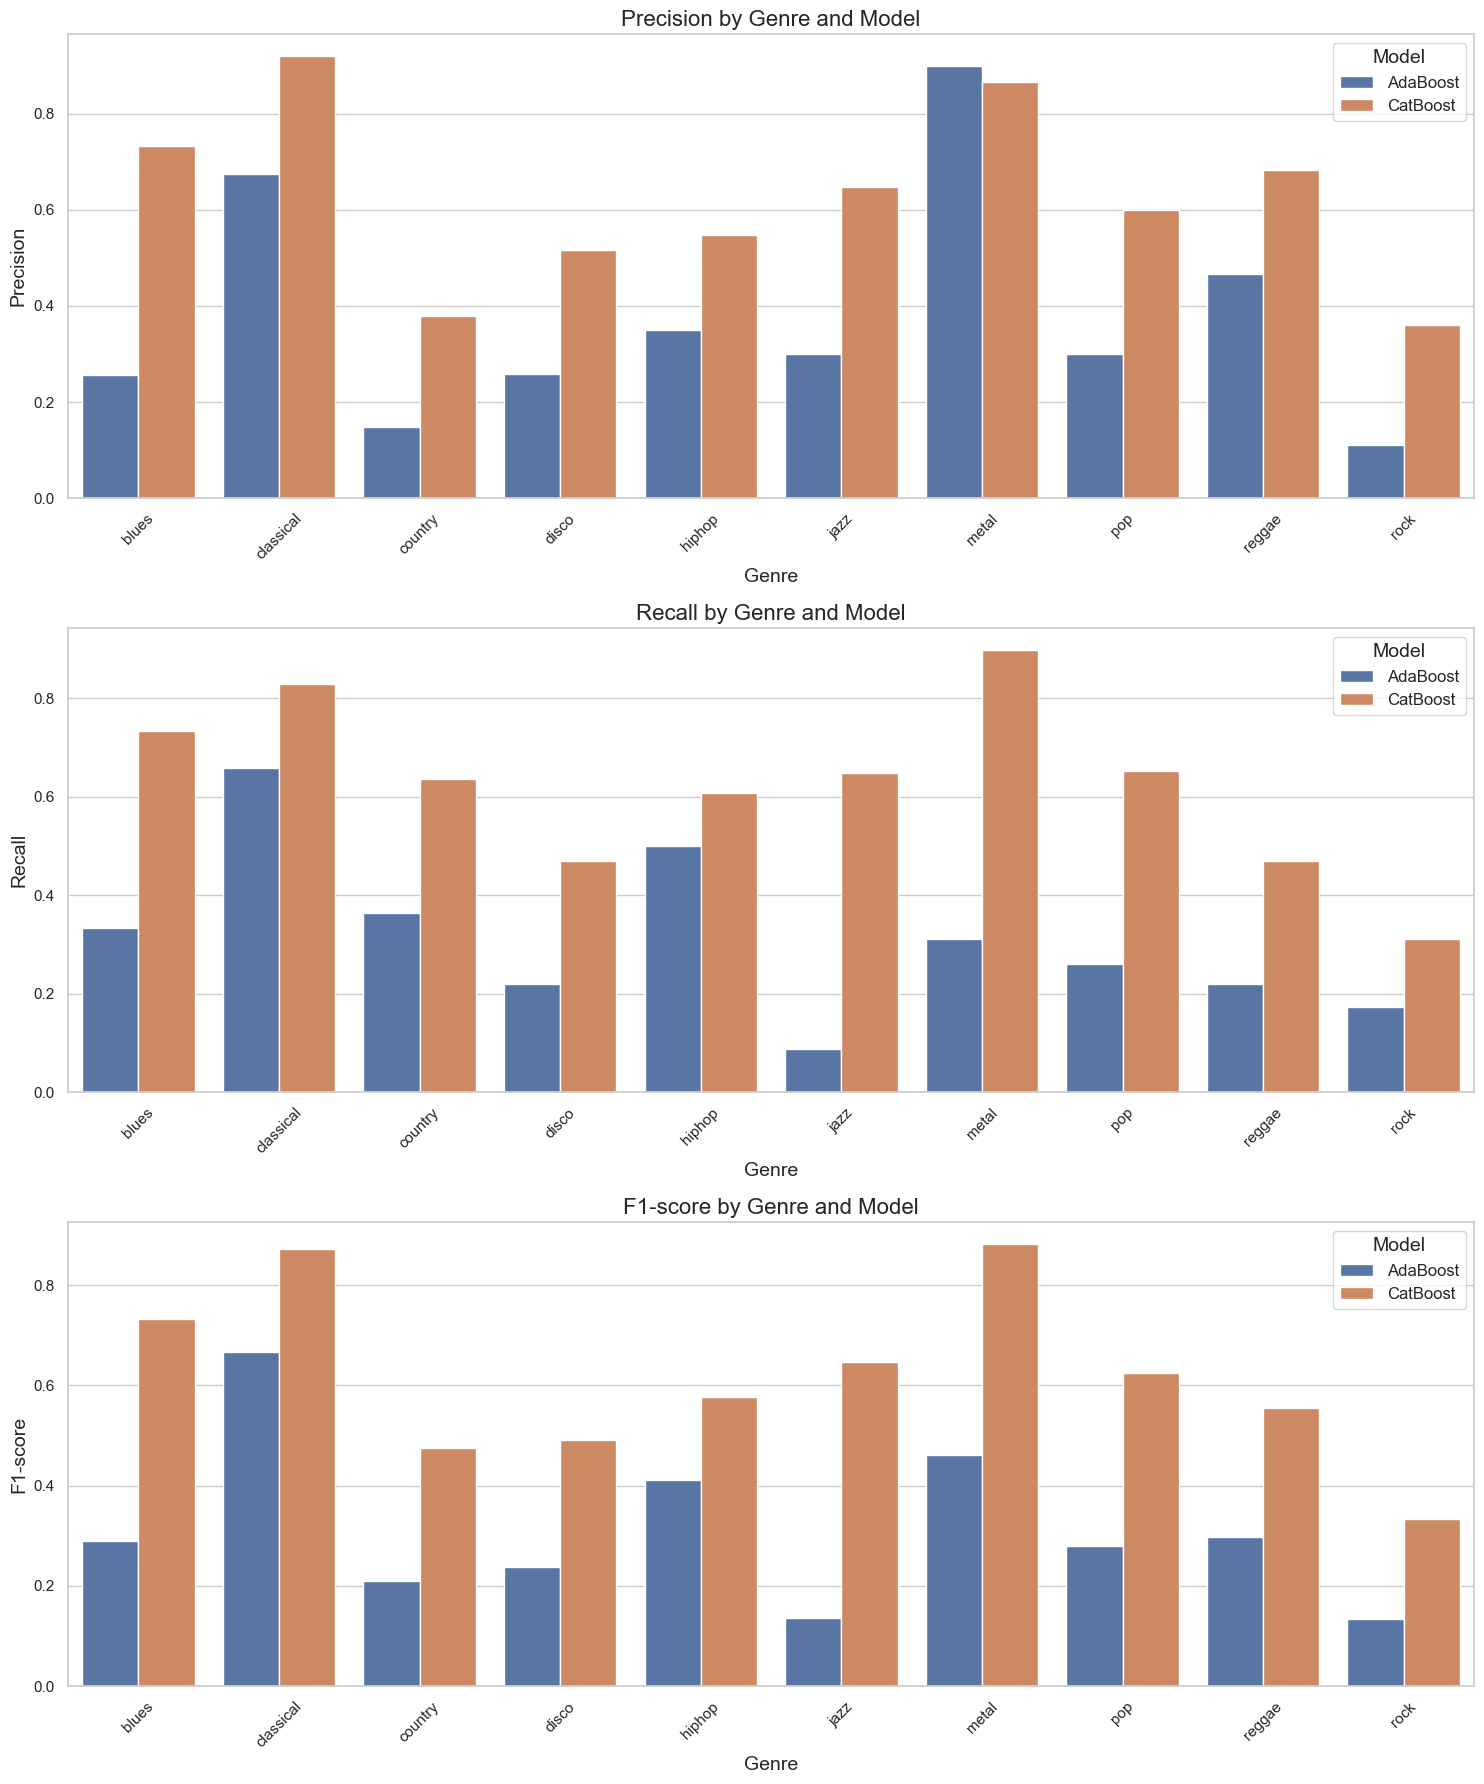

In [4]:

from sklearn.metrics import classification_report

# AdaBoost Report
y_pred_ada = ada_clf.predict(X_test)
ada_report = classification_report(y_test, y_pred_ada, target_names=le.classes_, output_dict=True)
# print("AdaBoost Classification Report:")
# print(classification_report(y_test, y_pred_ada, target_names=le.classes_))

# CatBoost Report
y_pred_cat = cat_clf.predict(X_test)
cat_report = classification_report(y_test, y_pred_cat, target_names=le.classes_, output_dict=True)
# print("CatBoost Classification Report:")
# print(classification_report(y_test, y_pred_cat, target_names=le.classes_))

import pandas as pd

# Convert reports to DataFrames
ada_df = pd.DataFrame(ada_report).transpose()
cat_df = pd.DataFrame(cat_report).transpose()

# Drop aggregate metrics if you only want per-class metrics
ada_df = ada_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)
cat_df = cat_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)

# Reset index to have class names as a column
ada_df.reset_index(inplace=True)
ada_df.rename(columns={'index': 'class'}, inplace=True)
cat_df.reset_index(inplace=True)
cat_df.rename(columns={'index': 'class'}, inplace=True)

# Merge the two reports on class
combined_df = pd.merge(ada_df, cat_df, on='class', suffixes=('_AdaBoost', '_CatBoost'))

# Melt the DataFrame for seaborn
melted_df = combined_df.melt(id_vars='class', 
                             value_vars=['precision_AdaBoost', 'precision_CatBoost',
                                         'recall_AdaBoost', 'recall_CatBoost',
                                         'f1-score_AdaBoost', 'f1-score_CatBoost'],
                             var_name='Metric_Model', 
                             value_name='Score')

# Split Metric_Model into separate Metric and Model columns
melted_df[['Metric', 'Model']] = melted_df['Metric_Model'].str.split('_', expand=True)
melted_df.drop('Metric_Model', axis=1, inplace=True)

import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(15, 18))

# List of metrics to plot
metrics = ['precision', 'recall', 'f1-score']

# Iterate over the metrics and create subplots
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 1, i)
    
    # Filter the DataFrame for the current metric
    data = melted_df[melted_df['Metric'] == metric]
    
    # Create a barplot
    sns.barplot(x='class', y='Score', hue='Model', data=data)
    
    # Set plot titles and labels
    plt.title(f'{metric.capitalize()} by Genre and Model', fontsize=16)
    plt.xlabel('Genre', fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust legend
    plt.legend(title='Model', fontsize=12, title_fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

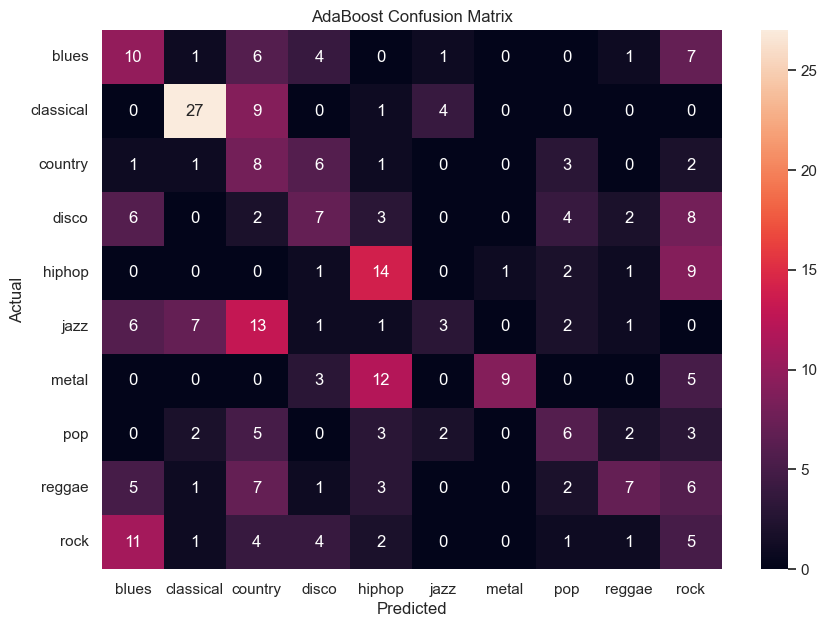

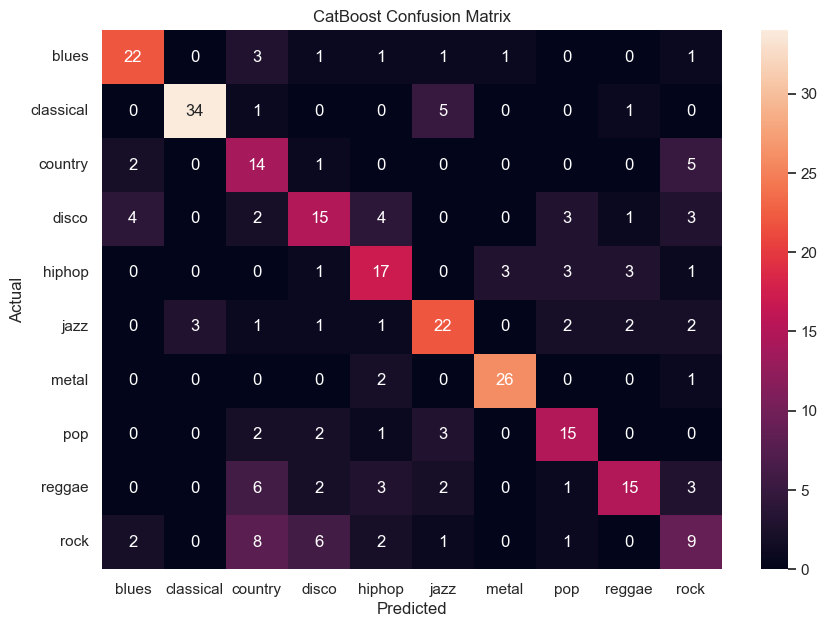

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# AdaBoost Confusion Matrix
cm_ada = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(10,7))
sns.heatmap(cm_ada, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('AdaBoost Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# CatBoost Confusion Matrix
cm_cat = confusion_matrix(y_test, y_pred_cat)
plt.figure(figsize=(10,7))
sns.heatmap(cm_cat, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('CatBoost Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [6]:
# Train tensorflow model

from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data to add a channels dimension
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

from keras import utils

from tensorflow.keras.utils import to_categorical

# Convert integer labels to one-hot vectors
y_train_cnn = to_categorical(y_train)
y_test_cnn = to_categorical(y_test)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define the CNN architecture
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    
    Dense(len(le.classes_), activation='softmax')  # Number of genres as output units
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',  # Suitable for multi-class classification
    optimizer='adam',                 # Adaptive optimizer
    metrics=['accuracy']              # Evaluation metric
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_cnn_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    X_train_cnn, y_train_cnn,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

from sklearn.metrics import classification_report

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred_cnn = model.predict(X_test_cnn)
y_pred_cnn_classes = y_pred_cnn.argmax(axis=1)
y_test_classes = y_test_cnn.argmax(axis=1)

# Classification Report
cnn_report = classification_report(y_test_classes, y_pred_cnn_classes, target_names=le.classes_)
print("\nCNN Classification Report:")
print(cnn_report)

import seaborn as sns

# Set aesthetic style
sns.set(style="whitegrid")

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save the model
model.save('genre_cnn_model.h5')

# Load the model
from tensorflow.keras.models import load_model
loaded_cnn = load_model('genre_cnn_model.h5')


ValueError: invalid literal for int() with base 10: 'blues'

AdaBoost Classification Report:
              precision    recall  f1-score   support

       blues       0.31      0.25      0.28        20
   classical       0.89      0.40      0.55        20
     country       0.42      0.50      0.45        20
       disco       0.40      0.20      0.27        20
      hiphop       0.27      0.45      0.34        20
        jazz       0.32      0.50      0.39        20
       metal       0.85      0.55      0.67        20
         pop       0.42      0.55      0.48        20
      reggae       0.32      0.30      0.31        20
        rock       0.16      0.15      0.15        20

    accuracy                           0.39       200
   macro avg       0.44      0.38      0.39       200
weighted avg       0.44      0.39      0.39       200

CatBoost Classification Report:
              precision    recall  f1-score   support

       blues       0.69      0.55      0.61        20
   classical       0.85      0.85      0.85        20
     country  

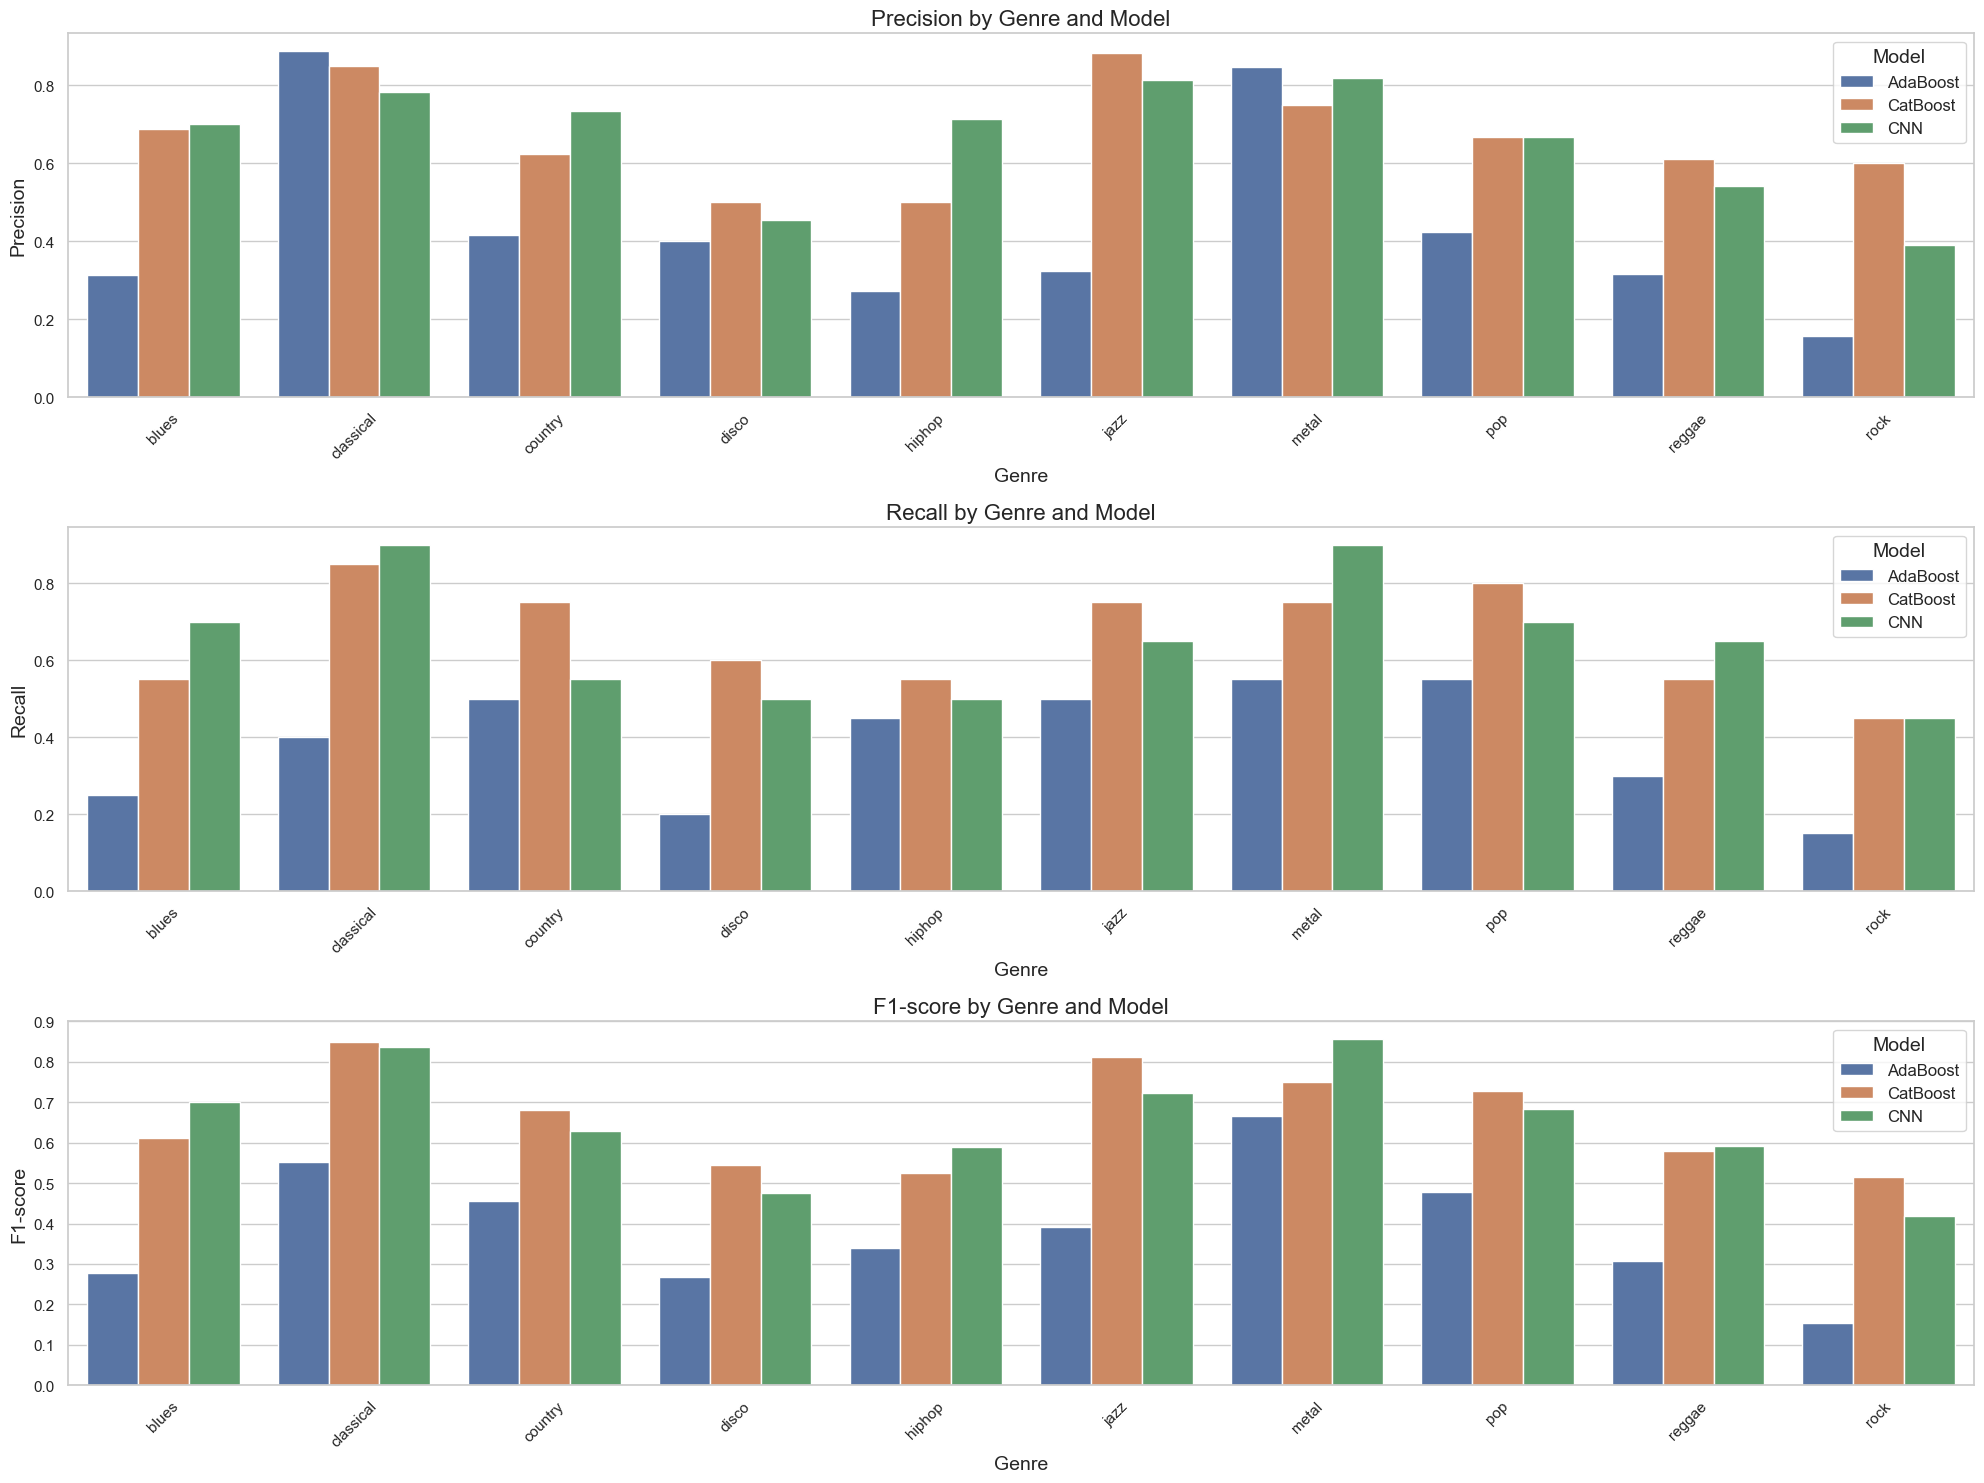

In [ ]:
# Compare all three models

# from sklearn.metrics import classification_report

# # For AdaBoost
y_pred_ada = ada_clf.predict(X_test)
ada_report = classification_report(y_test, y_pred_ada, target_names=le.classes_, output_dict=True)
print("AdaBoost Classification Report:")
print(classification_report(y_test, y_pred_ada, target_names=le.classes_))

# # For CatBoost
y_pred_cat = cat_clf.predict(X_test)
cat_report = classification_report(y_test, y_pred_cat, target_names=le.classes_, output_dict=True)
print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat, target_names=le.classes_))

# For CNN
y_pred_cnn = model.predict(X_test_cnn)
y_pred_cnn_classes = y_pred_cnn.argmax(axis=1)
cnn_report = classification_report(y_test_classes, y_pred_cnn_classes, target_names=le.classes_, output_dict=True)
print("CNN Classification Report:")
print(classification_report(y_test_classes, y_pred_cnn_classes, target_names=le.classes_))

ada_df = pd.DataFrame(ada_report).transpose()
cat_df = pd.DataFrame(cat_report).transpose()
cnn_df = pd.DataFrame(cnn_report).transpose()

# Drop aggregate metrics
ada_df = ada_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)
cat_df = cat_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)
cnn_df = cnn_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)

# Reset index to have 'class' as a column
ada_df = ada_df.reset_index().rename(columns={'index': 'class'})
cat_df = cat_df.reset_index().rename(columns={'index': 'class'})
cnn_df = cnn_df.reset_index().rename(columns={'index': 'class'})

# Rename columns to include model names
ada_df = ada_df.rename(columns={
    'precision': 'precision_AdaBoost',
    'recall': 'recall_AdaBoost',
    'f1-score': 'f1-score_AdaBoost'
})

cat_df = cat_df.rename(columns={
    'precision': 'precision_CatBoost',
    'recall': 'recall_CatBoost',
    'f1-score': 'f1-score_CatBoost'
})

cnn_df = cnn_df.rename(columns={
    'precision': 'precision_CNN',
    'recall': 'recall_CNN',
    'f1-score': 'f1-score_CNN'
})

# Merge the DataFrames on 'class'
merged_df = ada_df.merge(cat_df, on='class').merge(cnn_df, on='class')

# Melt the DataFrame to long format
melted_df = merged_df.melt(id_vars='class', 
                           value_vars=['precision_AdaBoost', 'precision_CatBoost', 'precision_CNN',
                                       'recall_AdaBoost', 'recall_CatBoost', 'recall_CNN',
                                       'f1-score_AdaBoost', 'f1-score_CatBoost', 'f1-score_CNN'],
                           var_name='Metric_Model', 
                           value_name='Score')

# Split 'Metric_Model' into 'Metric' and 'Model'
melted_df[['Metric', 'Model']] = melted_df['Metric_Model'].str.rsplit('_', n=1, expand=True)
melted_df = melted_df.drop('Metric_Model', axis=1)

# Set Seaborn style for aesthetics
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(20, 15))

# Define the list of metrics
metrics = ['precision', 'recall', 'f1-score']

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 1, i)
    
    # Filter the DataFrame for the current metric
    data = melted_df[melted_df['Metric'] == metric]
    
    # Create a barplot
    sns.barplot(x='class', y='Score', hue='Model', data=data)
    
    # Set plot titles and labels
    plt.title(f'{metric.capitalize()} by Genre and Model', fontsize=16)
    plt.xlabel('Genre', fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust legend
    plt.legend(title='Model', fontsize=12, title_fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()